In [1]:
import sys
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../Churn_Modelling.csv')
df =df.drop(columns=['RowNumber','CustomerId','Surname'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Seperate Dataframe into features and response
X, y = df.loc[:,df.columns != 'Exited'], df.Exited
print(X.shape, y.shape)

(10000, 10) (10000,)


In [4]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [5]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =0.7, random_state = 1)
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2228,644,France,Female,37,8,0.00,2,1,0,20968.88
5910,481,France,Female,39,6,0.00,1,1,1,24677.54
1950,680,France,Female,37,10,123806.28,1,1,0,81776.84
2119,690,France,Male,29,5,0.00,2,1,0,108577.97
5947,656,France,Female,45,7,145933.27,1,1,1,199392.14


In [7]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse=False), cat_features)
)
preprocess

[0, 3, 4, 5, 6, 7, 8, 9]
[1, 2]


ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2])])

In [8]:
# without SMOTE
model = make_pipeline(preprocess,RandomForestClassifier())
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [9]:
rf_param_grid = {
    'randomforestclassifier__n_estimators' : [50, 100, 150],
    'randomforestclassifier__max_features' : ['sqrt', 0.33],
    'randomforestclassifier__criterion' : ['gini', 'entropy']
}

In [10]:
rf_grid = GridSearchCV(model, rf_param_grid, cv= 10, scoring='accuracy')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2]

In [11]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
0.8632857142857144


In [12]:
print(f"Training Data Score: {rf_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_grid.score(X_test, y_test)}")

Training Data Score: 0.9994285714285714
Testing Data Score: 0.858


In [13]:
predictions = rf_grid.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
print(classification_report(y_test, predictions))

[[2291   82]
 [ 344  283]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2373
           1       0.78      0.45      0.57       627

    accuracy                           0.86      3000
   macro avg       0.82      0.71      0.74      3000
weighted avg       0.85      0.86      0.84      3000



In [14]:
# with SMOTE
model2 = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state= 1),
                  RandomForestClassifier())

In [15]:
rf_grid = GridSearchCV(model2, rf_param_grid, cv= 10, scoring='accuracy')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse=False),
                                                                         [1,
                                                                          2]

In [210]:
rf_grid['smote']

TypeError: 'GridSearchCV' object is not subscriptable

In [16]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 0.33, 'randomforestclassifier__n_estimators': 50}
0.843


In [17]:
print(f"Training Data Score: {rf_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_grid.score(X_test, y_test)}")

Training Data Score: 0.9997142857142857
Testing Data Score: 0.8436666666666667


In [18]:
predictions = rf_grid.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
print(classification_report(y_test, predictions))

[[2154  219]
 [ 250  377]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2373
           1       0.63      0.60      0.62       627

    accuracy                           0.84      3000
   macro avg       0.76      0.75      0.76      3000
weighted avg       0.84      0.84      0.84      3000



In [20]:
filename = '../Models/random_forest.sav'
joblib.dump(rf_grid, filename)
rf_model = joblib.load(filename)
print(rf_model.score(X_test, y_test))

0.8436666666666667


In [144]:
#pd.get_dummies(X).columns

In [145]:
print(list(pd.get_dummies(X).columns))
feature_importance = rf_grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
feature_importance   

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


array([0.11146821, 0.25088045, 0.09777828, 0.13542002, 0.17129201,
       0.01781841, 0.03410501, 0.11802847, 0.01290573, 0.01809762,
       0.01023375, 0.01038137, 0.01159067])

<AxesSubplot:>

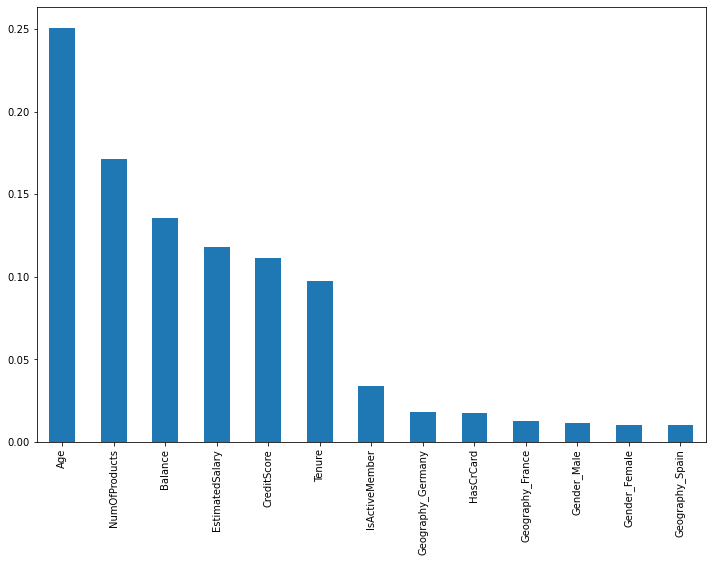

In [142]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(rf_grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_,
                            index = list(pd.get_dummies(X).columns))
feat_importances.nlargest(20).plot(kind='bar')

In [214]:
rf_grid.best_estimator_.named_steps['smote']

SMOTE(random_state=1)

In [212]:
rf_grid.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=0.33,
                                        n_estimators=50))])

In [215]:
rf_grid.best_estimator_.named_steps['randomforestclassifier']

RandomForestClassifier(criterion='entropy', max_features=0.33, n_estimators=50)

In [220]:
print(Counter(y_train))

Counter({0: 5590, 1: 1410})


In [221]:
from imblearn.over_sampling import SMOTE


X_res, y_res = SMOTE().fit_resample(X_train, y_train)
Counter(y_res)

ValueError: could not convert string to float: 'France'